# Assignment 1.3: Naive word2vec (40 points)

This task can be formulated very simply. Follow this [paper](https://arxiv.org/pdf/1411.2738.pdf) and implement word2vec like a two-layer neural network with matrices $W$ and $W'$. One matrix projects words to low-dimensional 'hidden' space and the other - back to high-dimensional vocabulary space.

![word2vec](https://i.stack.imgur.com/6eVXZ.jpg)

You can use TensorFlow/PyTorch and code from your previous task.

## Results of this task: (30 points)
 * trained word vectors (mention somewhere, how long it took to train)
 * plotted loss (so we can see that it has converged)
 * function to map token to corresponding word vector
 * beautiful visualizations (PCE, T-SNE), you can use TensorBoard and play with your vectors in 3D (don't forget to add screenshots to the task)

## Extra questions: (10 points)
 * Intrinsic evaluation: you can find datasets [here](http://download.tensorflow.org/data/questions-words.txt)
 * Extrinsic evaluation: you can use [these](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)

Also, you can find any other datasets for quantitative evaluation.

Again. It is **highly recommended** to read this [paper](https://arxiv.org/pdf/1411.2738.pdf)

Example of visualization in tensorboard:
https://projector.tensorflow.org

Example of 2D visualisation:

![2dword2vec](https://www.tensorflow.org/images/tsne.png)

# Solution

## Imports and constants

In [38]:
import numpy as np
import torch
from torch import nn
USE_COLAB = True

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [41]:
if USE_COLAB:
    !curl -O https://github.com/alex-kozinov/courses/blob/master/nlp-ipavlov/Task-1/batcher.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  161k    0  161k    0     0   236k      0 --:--:-- --:--:-- --:--:--  236k


In [ ]:

from batcher import SkipGramBatcherBase, read_corpus

## Skip-Gram Batcher impletation

In [2]:
class SkipGramBatcher(SkipGramBatcherBase):
    def __next__(self):
        """ Return next batch with order specified in self._permuted_indxs
            Return:
                centrals (np.array()): batch with one-hot vectors of central words. The size is (batch_size, vocabulary_size)
                neighbours (np.array()): batch with one-hot vectors of neighbour words. 
                                         One word for each central word. The size is (batch_size, vocabulary_size)
        """
        if len(self._batchs_positions) < self._batch_size:
            raise StopIteration

        centrals = []
        neighbours = []
        for i in range(self._batch_size):
            ind = self._batchs_positions.pop(0)
            c, n = self._get_word_indices(ind)
            c_onehot = self.index_to_onehot(c)
            n_onehot = self.index_to_onehot(np.random.choice(n))
            centrals.append(c_onehot)
            neighbours.append(n_onehot)

        centrals = np.vstack(centrals)
        neighbours = np.vstack(neighbours)
        assert centrals.shape == (self._batch_size, self._voc_size), 'centrals shape is ' + str(centrals.shape)
        assert neighbours.shape == (self._batch_size, self._voc_size), 'neighbours shape is ' + str(neighbours.shape)
        return centrals, neighbours

## Naive word2vec Pytorch module implementation

In [3]:
class NaiveWord2vec(nn.Module):
    def __init__(self, voc_size, embedding_dim):
        super(NaiveWord2vec, self).__init__()

        self.embedding_layer = nn.Embedding(voc_size, embedding_dim)
        self.linear_layer = nn.Linear(embedding_dim, voc_size, bias=False)
        self.activation = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        """ Forward pass of batch x
            Params:
                x (np.array): Batch with one-hot encoded vectors. The size is (batch_size, voc_size)
            Return:
                x (np.array): Batch with predicted neighbours. The size is (batch_size, voc_size)
        """
        x = self.embedding_layer(x)  # x: (batch_size, embedding_dim)
        x = self.linear_layer(x)  # x: (batch_size, voc_size)
        x = self.activation(x)  # x: (batch_size, voc_size)
        return x

# Learning process

## Define params

In [33]:
WINDOW_SIZE = 4
BATCH_SIZE = 2
VOCABULARY_SIZE = 1000

EMBEDDINGS_DIM = 150
EPOCH_NUM = 10
DROW_EVERY = 20

TEXT_PATH = 'data/text8'

loss_curve = []

## Preparation

### connect with colab:

### load data

In [16]:
corpus = read_corpus(TEXT_PATH)
dataset = SkipGramBatcher(corpus, WINDOW_SIZE, BATCH_SIZE, VOCABULARY_SIZE)

### create model

In [17]:
model = NaiveWord2vec(VOCABULARY_SIZE, EMBEDDINGS_DIM)

### create loss function

In [22]:
criterion = torch.nn.NLLLoss()

### create optimizer

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

## Learn process

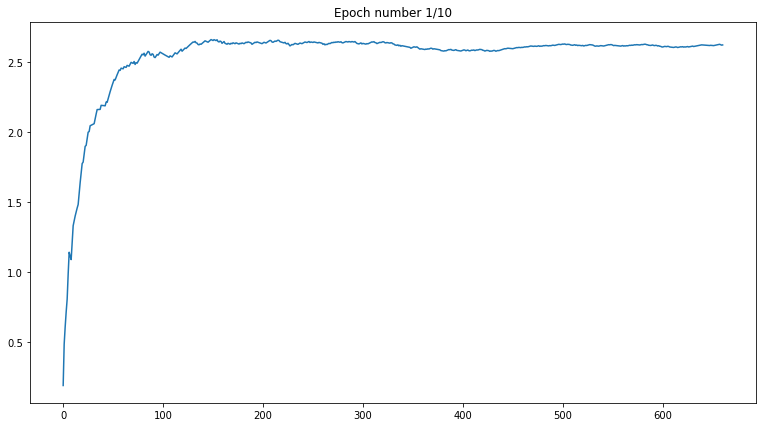

KeyboardInterrupt: 

In [34]:
loss_sum = 0
for epoch in range(EPOCH_NUM):
    for i, (context, target) in enumerate(dataset):
        tensor_context = torch.from_numpy(context).type(torch.LongTensor)
        tensor_target = torch.from_numpy(target).type(torch.LongTensor)

        model.zero_grad()
        pred = model(tensor_context)
        loss = criterion(pred, tensor_target)
        loss.backward()
        optimizer.step()
        single_loss = loss.detach().numpy()
        loss_sum += single_loss / BATCH_SIZE
        loss_curve.append(loss_sum / (len(loss_curve) + 11))
        if i % DROW_EVERY == 0:
            plt.figure(figsize=(13, 7))
            plt.title("Epoch number {}/{}".format(epoch+1, EPOCH_NUM))
            plt.plot(loss_curve, label="Train loss")
            clear_output(wait=True)
            plt.show()